In [3]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"


import celerite
import emcee
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits


from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

In [4]:
def qpp_model(t,A,B,tau_g,P,phase):
    
    F = A*np.exp(-(t-B)**2/(2*tau_g**2))*np.cos(((2*np.pi)/P)*t+phase)
    
    return F

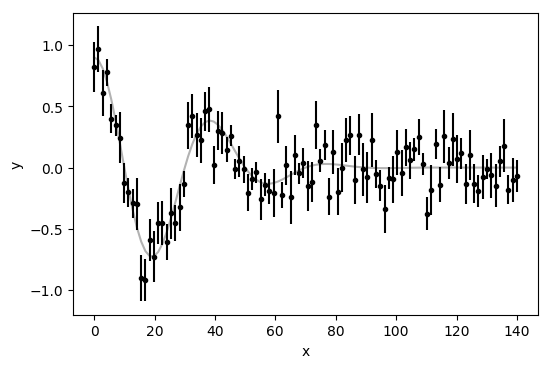

In [28]:
t = np.linspace(0, 140, 100)
QPP = qpp_model(t,0.9,0,30,40,0)
yerr = np.random.uniform(0.08, 0.22, len(t))

y = QPP + yerr * np.random.randn(len(t))
true_y = QPP

plt.plot(t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y")



In [49]:
yerr = np.random.uniform(0.08, 0.22, len(t))
yerr

array([ 0.20862018,  0.14371529,  0.19340077,  0.20195891,  0.10633849,
        0.11128869,  0.0965042 ,  0.1136516 ,  0.10635495,  0.08910272,
        0.1098313 ,  0.0836269 ,  0.16426456,  0.18392973,  0.08475205,
        0.08446771,  0.19317314,  0.19493006,  0.08286324,  0.1648492 ,
        0.10005943,  0.16073694,  0.08229232,  0.14675328,  0.19449761,
        0.08486544,  0.16403343,  0.20963185,  0.09649972,  0.19952956,
        0.11713823,  0.20712409,  0.21705238,  0.15698097,  0.13423754,
        0.15610044,  0.20044012,  0.21341251,  0.17353398,  0.20267492,
        0.10832991,  0.08355771,  0.17608516,  0.11071202,  0.19116638,
        0.21736368,  0.1273725 ,  0.12031131,  0.16061242,  0.20158732,
        0.20568046,  0.19487515,  0.20415285,  0.08024021,  0.09312291,
        0.18944911,  0.1464305 ,  0.21042927,  0.16451801,  0.18418446,
        0.18265924,  0.15805768,  0.12872169,  0.1245147 ,  0.18287963,
        0.18482778,  0.12067675,  0.08514584,  0.08173578,  0.19

In [29]:
# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [40]:
kernel

(SHOTerm(-0.1553692425878201, -0.34657359027997275, -1.877371575256707) + SHOTerm(-7.374992653425731, -5.347877383609776, -4.435552941838059))

In [30]:
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -41.44904102232886


In [32]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_S0', -0.15536924258782009),
             ('kernel:terms[0]:log_omega0', -1.8773715752567071),
             ('kernel:terms[1]:log_S0', -7.3749926534257311),
             ('kernel:terms[1]:log_Q', -5.3478773836097764),
             ('kernel:terms[1]:log_omega0', -4.4355529418380586)])

In [45]:
x = np.linspace(0, 140, 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

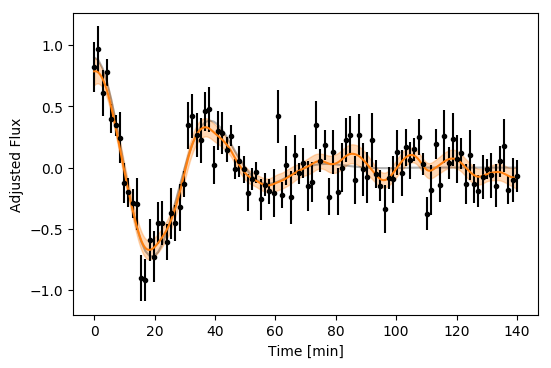

In [46]:
color = "#ff7f0e"
plt.plot(t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("Time [min]")
plt.ylabel("Adjusted Flux")